In [5]:
import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
def getSentences(text):
    nlp = English()
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    document = nlp(text)
    return [sent.string.strip() for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)


In [7]:
def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print(subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

Suppose you are a doctor faced with a patient who has a malignant tumor in his stomach. It is impossible to operate on the patient, but unless the tumor is destroyed the patient will die. There is a kind of ray that can be used to destroy the tumor. If the rays reach the tumor all at once at a sufficiently high intensity, the tumor will be destroyed. Unfortunately, at this intensity the healthy tissue that the rays pass through on the way to the tumor will also be destroyed. At lower intensities the rays are harmless to healthy tissue, but they will not affect the tumor either. What type of procedure might be used to destroy the tumor with the rays, and at the same time avoid destroying the healthy tissue?
Suppose -> ROOT
you -> nsubj
are -> ccomp
a -> det
doctor -> attr
faced -> acl
with -> prep
a -> det
patient -> pobj
who -> nsubj
has -> relcl
a -> det
malignant -> amod
tumor -> dobj
in -> prep
his -> poss
stomach -> pobj
. -> punct
you who , suppose doctor malignant , patient tumor

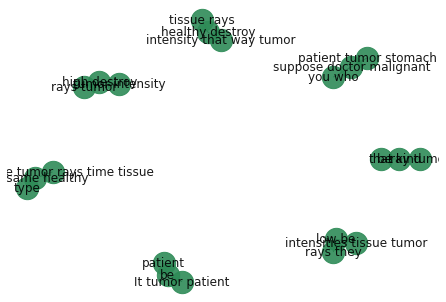

In [9]:
def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])
    
    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    with open('/Users/awenc/NUIM/CS440/data/tumor-problem.txt') as f:
        text = f.read()
    
    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    print(text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)